In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df=pd.read_excel('/content/density15.xlsx')

In [3]:
df

,x1,d (g cm-3),VE (cm3 mol-1)
0,0.0120,0.78710,−0.057
1,0.0310,0.79525,−0.157
2,0.0500,0.80300,−0.243
3,0.1000,0.82249,−0.446
4,0.1500,0.84037,−0.603
5,0.2002,0.85706,−0.730
6,0.2501,0.87224,−0.815
7,0.2974,0.88569,−0.877
8,0.3502,0.89965,−0.920
9,0.4001,0.91158,−0.924


Columns: Index(['x1', 'T', 'VE_(cm3_mol-1)', 'd_(g_cm-3)'], dtype='object')
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.9759 - val_loss: 0.4884
Epoch 2/200
1/1 [==============================] - 0s 110ms/step - loss: 1.4437 - val_loss: 1.4527
Epoch 3/200
1/1 [==============================] - 0s 88ms/step - loss: 0.9612 - val_loss: 1.6763
Epoch 4/200
1/1 [==============================] - 0s 49ms/step - loss: 0.9233 - val_loss: 1.3223
Epoch 5/200
1/1 [==============================] - 0s 57ms/step - loss: 0.8996 - val_loss: 0.6255
Epoch 6/200
1/1 [==============================] - 0s 57ms/step - loss: 0.8627 - val_loss: 0.6580
Epoch 7/200
1/1 [==============================] - 0s 73ms/step - loss: 0.8783 - val_loss: 0.5428
Epoch 8/200
1/1 [==============================] - 0s 118ms/step - loss: 0.8210 - val_loss: 0.8269
Epoch 9/200
1/1 [==============================] - 0s 153ms/step - loss: 0.8084 - val_loss: 0.8944
Epoch 10/200
1/1 [=======================

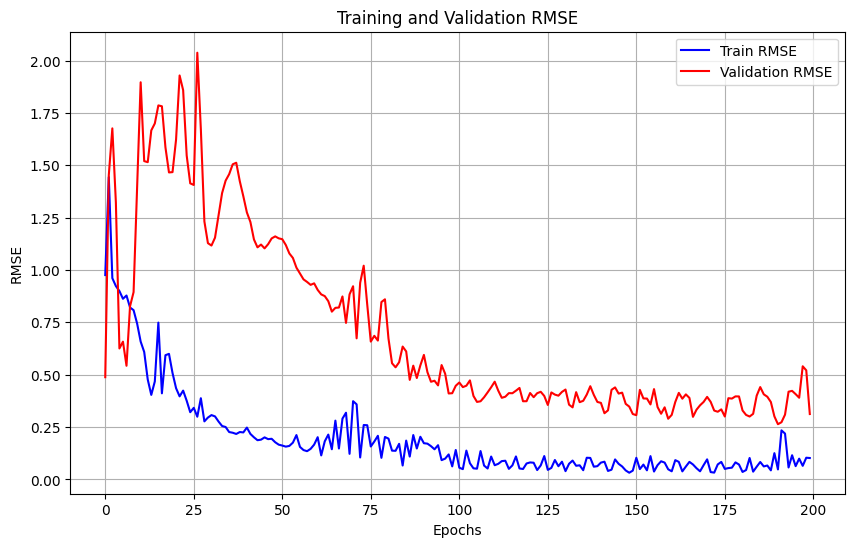

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Assuming df is already defined and contains the necessary data
# Adding constant temperature T as a feature
# Adding constant temperature T as a feature
df['T'] = 303.15


# Rename columns to remove special characters and spaces
df['VE_(cm3_mol-1)'] = df['VE (cm3 mol-1)'].str.replace('−', '-') # Replace special character if needed.
df['VE_(cm3_mol-1)'] = df['VE_(cm3_mol-1)'].astype(float) # Converting the column to float
df['d_(g_cm-3)'] = df['d (g cm-3)']  # Rename with underscores

# Drop original columns with special characters and spaces
df = df.drop(['VE (cm3 mol-1)', 'd (g cm-3)'], axis=1)

# Verify the column names
print("Columns:", df.columns)

# Input features and target variables
X = df[['x1', 'T']].values
y = df[['d_(g_cm-3)', 'VE_(cm3_mol-1)']].values

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Build the ANN model with more layers
model = Sequential()
model.add(Dense(64, input_dim=X_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))  # Additional hidden layer
model.add(Dense(8, activation='relu'))   # Additional hidden layer
model.add(Dense(2))  # Output layer for two target variables

# Custom RMSE loss function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Compile the model with a different optimizer and increased learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=rmse)

# Train the model
history = model.fit(X_scaled, y_scaled, epochs=200, batch_size=64, validation_split=0.2)

# Predict and inverse transform the results
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_original = scaler_y.inverse_transform(y_scaled)

# Calculate the error percentage (MAPE) for each target variable separately
mape_density = np.mean(np.abs((y_original[:, 0] - y_pred[:, 0]) / y_original[:, 0])) * 100
mape_ve = np.mean(np.abs((y_original[:, 1] - y_pred[:, 1]) / y_original[:, 1])) * 100

print(f"Mean Absolute Percentage Error (MAPE) for Density: {mape_density:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE) for VE: {mape_ve:.2f}%")

# Prepare a comparison DataFrame
comparison = pd.DataFrame({
    'x1': X[:, 0],
    'T': X[:, 1],
    'd_actual': y_original[:, 0],
    'd_predicted': y_pred[:, 0],
    'VE_actual': y_original[:, 1],
    'VE_predicted': y_pred[:, 1],
})

# Display the comparison table
print(comparison.to_string(index=False))

# Save the comparison DataFrame to an Excel file
comparison.to_excel('comparison_results.xlsx', index=False)

print("Comparison results saved to 'comparison_results.xlsx'")

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train RMSE', color='blue')
plt.plot(history.history['val_loss'], label='Validation RMSE', color='red')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Adding constant temperature T as a feature
df['T'] = 283.15


# Input features and target variables
X = df[['x1', 'T']].values
y = df[['d_(g_cm-3)', 'VE_(cm3_mol-1)']].values

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Build the ANN model with more layers
model = Sequential()
model.add(Dense(64, input_dim=X_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))  # Additional hidden layer
model.add(Dense(8, activation='relu'))   # Additional hidden layer
model.add(Dense(2))  # Output layer for two target variables

# Custom RMSE loss function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Compile the model with a different optimizer and increased learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=rmse)

# Train the model
history = model.fit(X_scaled, y_scaled, epochs=500, batch_size=16, validation_split=0.2)

# Predict and inverse transform the results
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_original = scaler_y.inverse_transform(y_scaled)

# Calculate the error percentage (MAPE) for each target variable separately
mape_density = np.mean(np.abs((y_original[:, 0] - y_pred[:, 0]) / y_original[:, 0])) * 100
mape_ve = np.mean(np.abs((y_original[:, 1] - y_pred[:, 1]) / y_original[:, 1])) * 100

print(f"Mean Absolute Percentage Error (MAPE) for Density: {mape_density:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE) for VE: {mape_ve:.2f}%")

# Prepare a comparison DataFrame
comparison = pd.DataFrame({
    'x1': X[:, 0],
    'T': X[:, 1],
    'd_actual': y_original[:, 0],
    'd_predicted': y_pred[:, 0],
    'VE_actual': y_original[:, 1],
    'VE_predicted': y_pred[:, 1],
})

# Save the comparison DataFrame to an Excel file
comparison.to_excel('comparison_results.xlsx', index=False)

print("Comparison results saved to 'comparison_results.xlsx'")

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train RMSE', color='blue')
plt.plot(history.history['val_loss'], label='Validation RMSE', color='red')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()